In [1]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#jupyter notebook --notebook-dir=/PycharmProjects/Top-N-RecSys/

In [3]:
# Import Dataset

with open('./data/Cell_Phones_and_Accessories.json') as json_file:      
    data = json_file.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects.
    data = list(map(json.loads, data)) 
#electronics_df=pd.read_json('data/Cell_Phones_and_Accessories.json', lines=True)

In [ ]:
electronics_df = pd.DataFrame(data)
electronics_df.head()

In [33]:
# Dropping unused variables
electronics_df.drop(['image', 'reviewText', 'reviewTime', 'reviewerName', 'style', 'summary', 'unixReviewTime'
, 'verified', 'vote'],axis=1,inplace=True)
electronics_df.head()

,asin,overall,reviewerID
0,098949232X,5,A1GG51FWU0XQYH
1,098949232X,5,AVFIDS9RK38E0
2,098949232X,5,A2S4AVR5SJ7KMI
3,098949232X,5,AEMMMVOR9BFLI
4,098949232X,5,A2DZXMBTY7KLYP


In [34]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  10063255
Number of columns:  3


In [35]:
#Check the datatypes
electronics_df.dtypes

asin          object
overall        int64
reviewerID    object
dtype: object

In [36]:
electronics_df['overall'] = electronics_df['overall'].astype(float)
#Check the datatypes after changing
electronics_df.dtypes

asin           object
overall       float64
reviewerID     object
dtype: object

In [37]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 asin          0
overall       0
reviewerID    0
dtype: int64


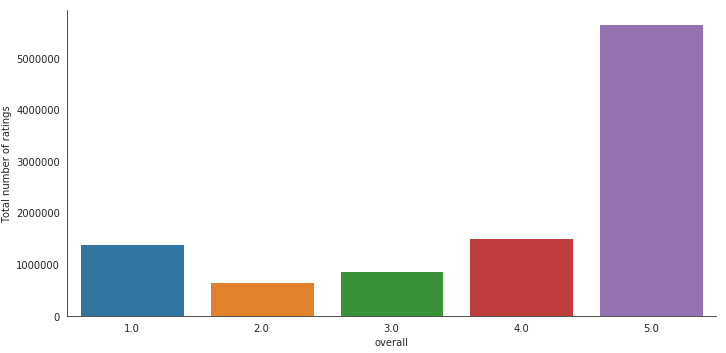

In [38]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=electronics_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [39]:

# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df['asin'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df['reviewerID'].nunique())

Number of unique users in Raw data =  589534
Number of unique product in Raw data =  6211701


In [49]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:20000,0:]
electronics_df1.head()


,asin,overall,reviewerID
0,098949232X,5.0,A1GG51FWU0XQYH
1,098949232X,5.0,AVFIDS9RK38E0
2,098949232X,5.0,A2S4AVR5SJ7KMI
3,098949232X,5.0,AEMMMVOR9BFLI
4,098949232X,5.0,A2DZXMBTY7KLYP


In [50]:
electronics_df1['user_index'] = np.arange(0, electronics_df1.shape[0], 1)
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
asin          20000 non-null object
overall       20000 non-null float64
reviewerID    20000 non-null object
user_index    20000 non-null int32
dtypes: float64(1), int32(1), object(2)
memory usage: 547.0+ KB


In [51]:
#Create matrix with row 'asin' and col 'reviewerID'
pivot_df = electronics_df1.pivot(index = 'user_index', columns ='reviewerID', values = 'overall').fillna(0)
pivot_df.head()

reviewerID,A0265436JMR91F9LHBXT,A0564474RQMYYH3H95UC,A0617213KGAVUMXH6NK4,A0651739GZEV56UR6T54,A0755549VZ3OU6OE9EHO,A09781781CO6UDP1IQGW,A1007QNV235TUF,A100C9FK1V6VVT,A100MPD67FD3ID,A100MXMK2MBY0D,...,AZVYIPWW5I9O9,AZW1U1OGO8MRO,AZW6WE7UXAMU0,AZWBG6PYODWTX,AZWK48QT7IC8I,AZWZ8OHF59J27,AZXNSJHBKGLO6,AZYU8M791SIFC,AZYXGC2G6GM71,AZZ5U380URI57
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
